In [2]:
import numpy as np
import pckt
#from fitting import fit
import RockSat_json.RockSat_json 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
plt.rcParams['text.usetex']=True

In [3]:
class pck:
    def __init__(self, path, num, sw_type):
        self.path = path
        self.num = num
        self.sw_type = sw_type
        data = pd.read_json(path)
        data = data['packets'][sw_type][f'{self.num}']
        self.data = data
        self.start = data['Start']/1000
        self.stop  = data['Stop']/1000
        self.grnd = data['GroundType']
        self.iv = pd.DataFrame({
                    'V': np.array(self.data['Voltage'][140:240]), 
                    'I0': -np.array(self.data['Current0'][140:240]), 
                    'I1': -np.array(self.data['Current1'][140:240]), 
                    'I2': -np.array(self.data['Current2'][140:240])
                    })

In [4]:
# --- Physical constants ---
e = 1.602e-19       # elementary charge [C]
k_B = 1.381e-23     # Boltzmann constant [J/K]
amu = 1.6605e-27    # atomic mass unit [kg]
m_e = 9.109e-31      # electron mass [kg]

# --- Probe geometry ---
R_cm = (3.0 / 16.0) * 2.54  # Radius [cm]
L_cm = 3.25 * 2.54          # Length [cm]
A_cm2 = 2.0 * np.pi * R_cm * L_cm + np.pi * (R_cm ** 2)
probe_area = A_cm2 * 1e-4   # Convert to m^2

ion_mass_amu = 39.948       # Argon by default
m_i = ion_mass_amu * amu    # Ion mass [kg]

# --- Load data (no headers) ---
path = f'C:/Users/carso/OneDrive/Documents/DAPPEr/Github/DAPPEr/Data/UDIP_4_800s.json'
data = pd.read_json(path)['packets']['Full']
print(len(data))
dat = pck(path, 300, 'Full')
df = dat.iv

903


In [5]:
from scipy.optimize import curve_fit
def model(x, V0, a, m):
    I = a * ((x - V0))**m
    return I

# def model(x, V0, ne, Te, m, b0):
#     e = 1.602e-19     # C
#     k = 1.381e-23     # J/K
#     m_e = 9.109e-31   # kg
#     R_cm = (3.0 / 16.0) * 2.54  # Radius [cm]
#     L_cm = 3.25 * 2.54          # Length [cm]
#     A_cm2 = 2.0 * np.pi * R_cm * L_cm + np.pi * (R_cm ** 2)
#     probe_area = A_cm2 * 1e-4   # Convert to m^2
#     I = ne * probe_area * e * np.sqrt(k * Te/(2 * np.pi * m_e))  * ((x - V0))**m + b0
#     return I

# def model(x, V0, Te, m, b0):
#     e = 1.602e-19     # C
#     k = 1.381e-23     # J/K
#     m_e = 9.109e-31   # kg
#     R_cm = (3.0 / 16.0) * 2.54  # Radius [cm]
#     L_cm = 3.25 * 2.54          # Length [cm]
#     A_cm2 = 2.0 * np.pi * R_cm * L_cm + np.pi * (R_cm ** 2)
#     probe_area = A_cm2 * 1e-4   # Convert to m^2
#     I = 4e10 * probe_area * e * np.sqrt(k * Te/(2 * np.pi * m_e))  * ((x - V0))**m + b0
#     return I

def gen_fit(x_raw,y_raw):
    x = x_raw; y = y_raw
    
    g = [2, 1e-7, 1/2]
    popt, pcov = curve_fit(model,x ,y, p0 = g, maxfev = 10000, method = 'lm')

    # g = [-2, 4e10, 300, 0.5, 0]
    # b = (
    #     [-5, 1e5, 50, 0 , -100],
    #     [5, 1e15, 1e5, 1, 100]
    # )
    # popt, pcov = curve_fit(model,x ,y, p0 = g, bounds = b, maxfev = 10000)

    # g = [-2, 1000, 0.5, 0]
    # b = (
    #     [-5, 50, 0 , -100],
    #     [5,  1e5, 1, 100]
    # )
    # popt, pcov = curve_fit(model,x ,y, p0 = g, bounds = b, maxfev = 10000)

    max_1 = np.max(x)
    min_1 = np.min(x)
    t = np.linspace(min_1,max_1,num=1000)
    return t, model(t,*popt),popt,pcov #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0]

3.155425219941349


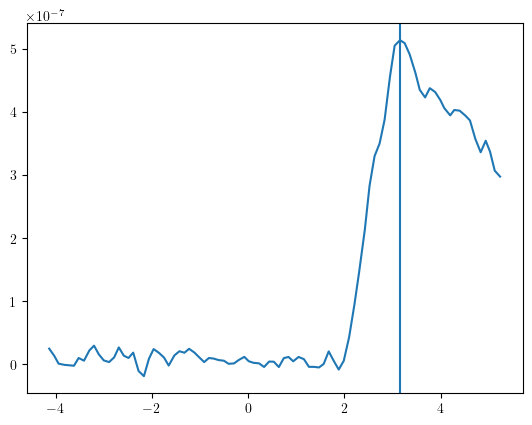

In [6]:
from scipy.ndimage import gaussian_filter1d
# df['sm'] = df['I0'].rolling(10).mean().fillna(0)

# First and second derivatives
df['dIdV'] = np.gradient(df['I0'], df['V'])

dIdV_av = df['dIdV'].rolling(10).mean()

dVmax = df['V'][np.argmax(dIdV_av)]
print(dVmax)
plt.plot(df['V'], dIdV_av)
plt.axvline(dVmax)

In [7]:
V_av = df["V"].rolling(10).mean()
I0_av = df["I0"].rolling(10).mean()
zeros = np.where(np.diff(np.sign(I0_av)))[0]
zeros

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 38])

In [8]:
# plt.plot(V_av, I0_av)
# plt.vlines(V_av[zeros], np.ones_like(zeros)* -1e-6, np.ones_like(zeros)* 1.5e-6)
# plt.ylim((-.075e-6,1.3e-6))
# print(V_av[zeros])

In [9]:
esat = df[df['V'] > dVmax]
V, I, popt, pcov = gen_fit(esat['V'], esat['I0'])

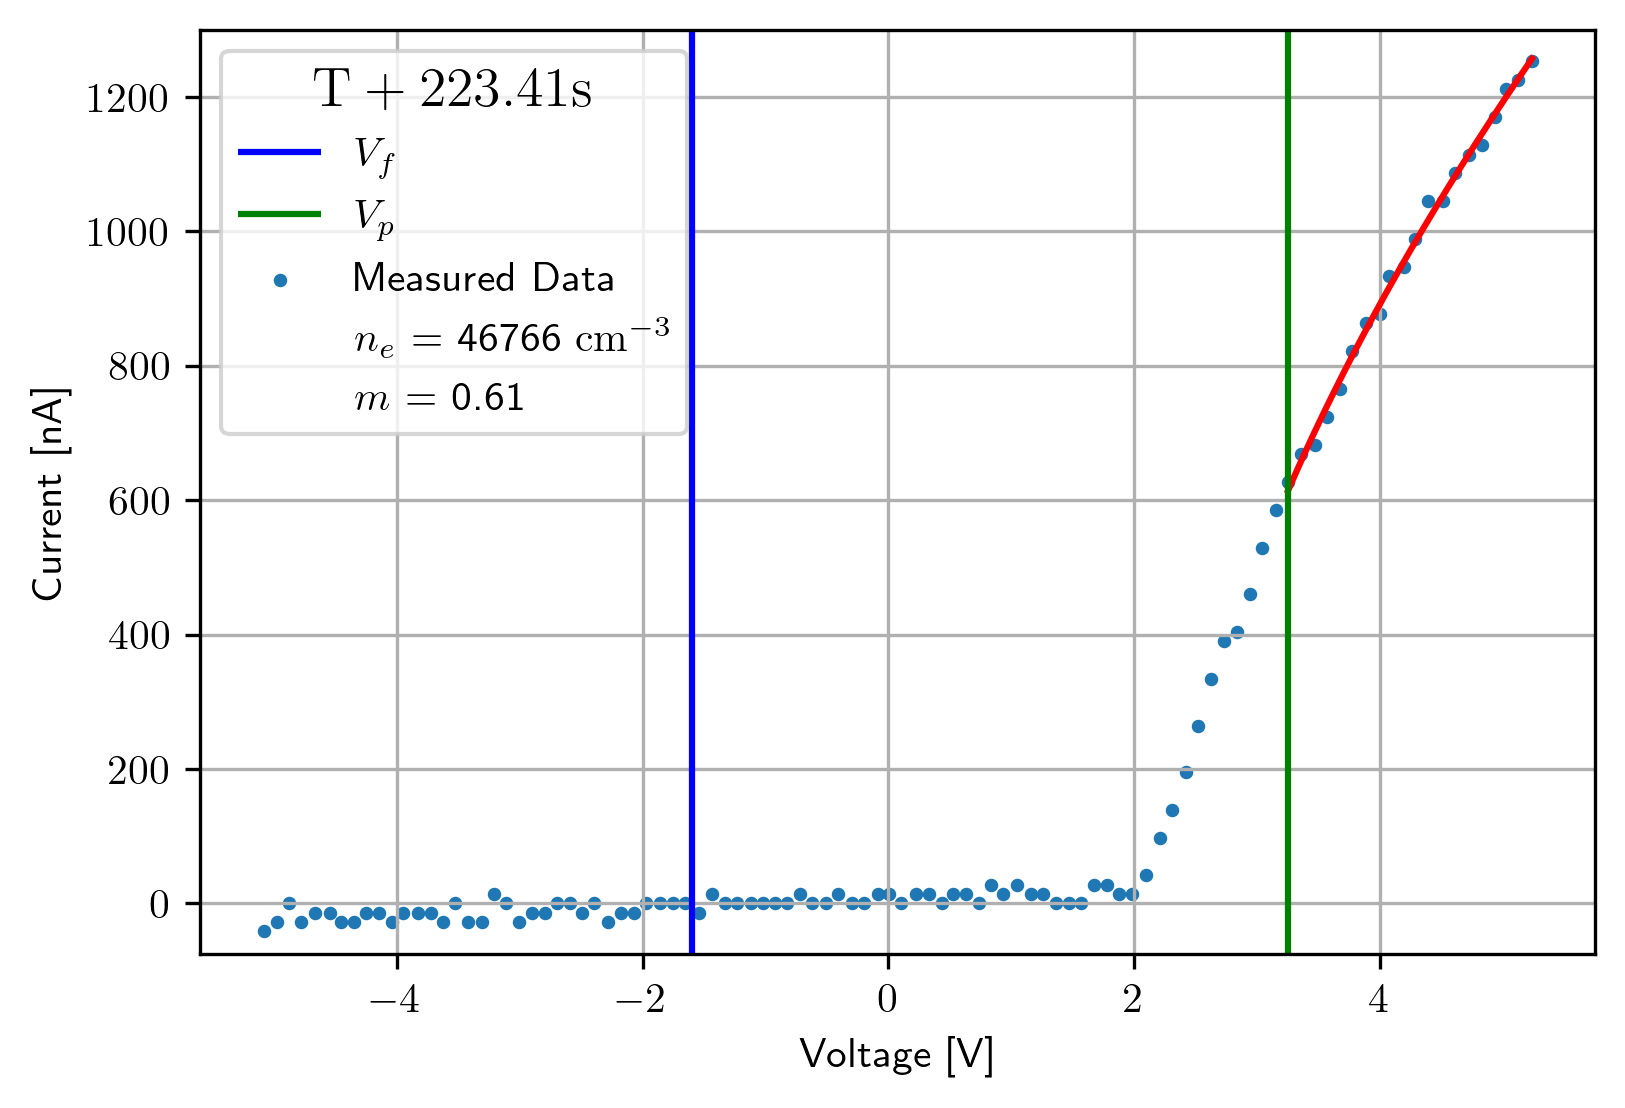

In [12]:
plt.figure(figsize=(6, 4), dpi=300)  # adjust size and resolution
b = 300
ne = popt[1]/(probe_area * e) * np.sqrt((2 * np.pi * m_e)/(k_B * 500)) /1e6
plt.plot(V,I*1e9, c = "r")
#float_potential = plt.vlines([ 1.76], [ -1e3], [1.5e3], colors = "b", label = r"$V_0$")
float_potential = plt.vlines(V_av[zeros], np.ones_like(zeros)* -1e3, np.ones_like(zeros)* 1.5e3,colors = "b", label = r"$V_f$")
plasma_potential = plt.vlines([V[0]], [-1e3], [1.5e3], colors = "g", label = r"$V_p$")

measured_data = plt.scatter(df['V'], df['I0']*1e9, s = 5, label = r"Measured Data")
#plt.vlines([popt[1]], [-150], [2000], colors = "g")
# line_fit, = plt.plot(V, I, c="r")
param1 = patches.Patch(color='none', label= r"$n_e$ = " + str(ne)[0:5] +r"${~\rm cm}^{-3}$")
param2 = patches.Patch(color='none', label= fr"$m$ = {popt[2]:.2f} ")


# Combine all legend handles
plt.legend(handles = [float_potential, plasma_potential, measured_data, param1, param2], title = r"$ \rm T+223.41s$", title_fontsize = 13.5)
plt.ylim((-.075e3,1.3e3))
plt.xlabel(r"Voltage [V]")
plt.ylabel(r"Current [nA]")
plt.grid(True)
plt.savefig(r"sample_IV_curve_v4.png", bbox_inches='tight')